In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.random import generate_standard_normal
from torchlake.image_generation.models.vae import VAE, VAELoss
from torchlake.common.controller.trainer import SingleInputMutltOutputRegressionTrainer
from torchlake.common.controller.weight_manager import WeightManager
from torchvision import transforms

# Setting

In [2]:
IMAGE_SIZE = 28
BATCH_SIZE = 2048

In [3]:
DEVICE = torch.device("cuda:0")

In [4]:
artifact_path = Path("../../artifacts/vae")
data_path = Path("../../data/mnist")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
    ]
)

In [6]:
train_data = torchvision.datasets.MNIST(
    root=data_path.as_posix(),
    transform=preprocess,
    download=True,
)

In [7]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

# model

In [24]:
LATENT_DIM = 20

In [8]:
model = VAE(
    input_channel=1,
    image_size=28 * 28,
    hidden_dim=256,
    latent_dim=LATENT_DIM,
).to(DEVICE)

In [9]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
VAE                                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       200,960
│    └─ReLU: 2-2                         --
├─ModuleDict: 1-2                        --
│    └─Linear: 2-3                       5,140
│    └─Linear: 2-4                       5,140
├─Sequential: 1-3                        --
│    └─Linear: 2-5                       5,376
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       201,488
Total params: 418,104
Trainable params: 418,104
Non-trainable params: 0

# train

In [10]:
EPOCHES = 15

In [11]:
trainer = SingleInputMutltOutputRegressionTrainer(EPOCHES, DEVICE)

In [12]:
criterion = VAELoss(kld_weight=1, loss_type="mse")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [14]:
scaler = torch.cuda.amp.GradScaler()

In [15]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler=scheduler, scaler=scaler)

Enable AMP: True
Calculating dataset size...


100%|██████████| 29/29 [00:08<00:00,  3.41it/s]


Training...


100%|██████████| 29/29 [00:09<00:00,  2.98it/s]


Epoch 1 : 105.95558376969964 (0%)


100%|██████████| 29/29 [00:09<00:00,  2.94it/s]


Epoch 2 : 59.38141237456222 (-44%)


100%|██████████| 29/29 [00:08<00:00,  3.29it/s]


Epoch 3 : 49.53957103860789 (-17%)


100%|██████████| 29/29 [00:09<00:00,  3.10it/s]


Epoch 4 : 44.92611391790982 (-9%)


100%|██████████| 29/29 [00:09<00:00,  3.20it/s]


Epoch 5 : 42.33658968169114 (-6%)


100%|██████████| 29/29 [00:08<00:00,  3.26it/s]


Epoch 6 : 40.63089041874327 (-4%)


100%|██████████| 29/29 [00:08<00:00,  3.24it/s]


Epoch 7 : 39.39847091148639 (-3%)


100%|██████████| 29/29 [00:09<00:00,  3.18it/s]


Epoch 8 : 38.48544469372979 (-2%)


100%|██████████| 29/29 [00:08<00:00,  3.29it/s]


Epoch 9 : 37.761109450767776 (-2%)


100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


Epoch 10 : 37.159627454034215 (-2%)


100%|██████████| 29/29 [00:08<00:00,  3.22it/s]


Epoch 11 : 36.664520526754444 (-1%)


100%|██████████| 29/29 [00:08<00:00,  3.38it/s]


Epoch 12 : 36.22718403257172 (-1%)


100%|██████████| 29/29 [00:08<00:00,  3.41it/s]


Epoch 13 : 35.89353837638066 (-1%)


100%|██████████| 29/29 [00:08<00:00,  3.34it/s]


Epoch 14 : 35.688353571398515 (-1%)


100%|██████████| 29/29 [00:08<00:00,  3.33it/s]

Epoch 15 : 35.598101254167226 (0%)


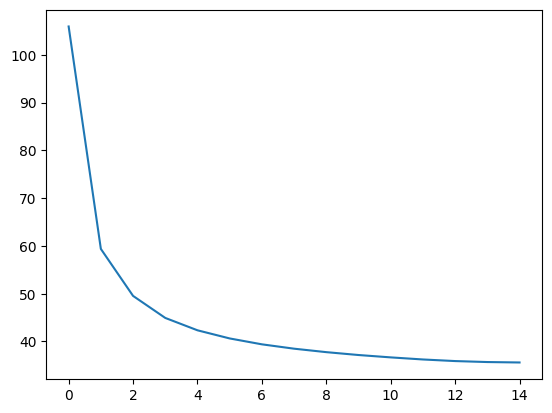

In [16]:
plt.plot(training_loss)

In [19]:
manager = WeightManager(artifact_path.joinpath("vae.pth").as_posix())

In [20]:
model_path = manager.get_filename()
model_path

WindowsPath('../../artifacts/vae/vae.pth')

In [21]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\vae\vae.pth, model size is 1.6MiB


In [22]:
manager.load_weight(model_path, model)

# Eval

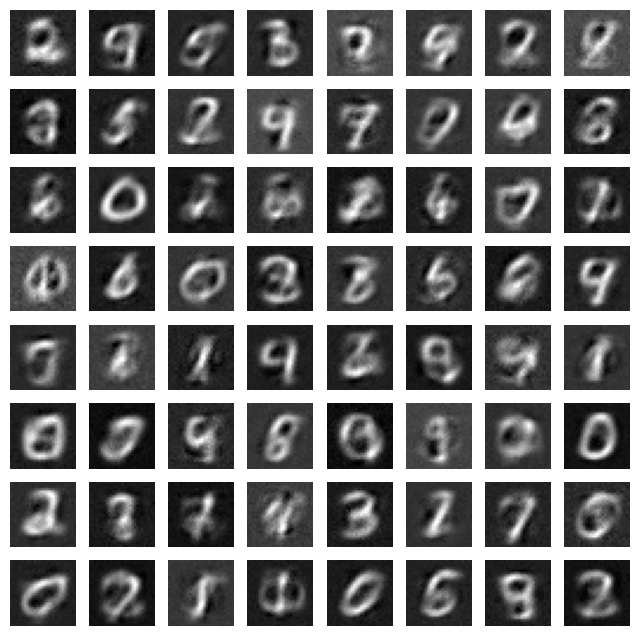

In [30]:
# 合成圖片

model.eval()
with torch.no_grad():
    noise = generate_standard_normal(64, LATENT_DIM).to(DEVICE)
    gen_img = model.decode(noise, (-1, 1, IMAGE_SIZE, IMAGE_SIZE))
    
    plot_grids(
        img_tensor_to_np(gen_img),
        num_row=8,
        num_col=8,
        is_gray_scale=True,
    )